In [24]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress
import matplotlib.lines as mlines

In [25]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [27]:
project = signac.get_project("/home/erjank_project/itic-project")


state_dict = {"size": "small",
              "density": 0.9,
              "process": "quench",
              "molecule": "ITIC",
              "kT_reduced": 0.9}

In [31]:
def make_me_a_graph(state_dict = {"size": "small",
                                  "density": 0.9,
                                  "process": "quench",
                                  "molecule": "ITIC",
                                  "kT_reduced": 0.9}):
    
    job_list = project.find_jobs(state_dict)

    fig = plt.figure()
    ax = plt.subplot(111)
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        tspf = job.sp['n_steps'] / 100
        msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
        y = msd[-15:]
        x = np.arange(0, len(y), 1) * tspf
        plt.plot(x, y, label=job.sp['kT_reduced'], color='#735632')
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        plt.plot(x, x*slope + intercept, linestyle = 'dotted', color = '#de8110')
        #plt.xlim(0, 6000)

    plt.title("MSD of ITIC at %sden, %s kT" % (job.sp['density'], job.sp['kT_reduced']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("MSD", fontsize=14)

    sline = mlines.Line2D([], [], color='#de8110', linestyle='dotted',
                           label='slope of msd' )
    msdline = mlines.Line2D([], [], color='#735632', linestyle='solid',
                           label='msd of ITIC' )
    ax.legend(loc='lower right', ncol=1, handles=[msdline, sline])

    print("slope is:")
    print("%10.5e"% slope)

    plt.show()

slope is:
1.04224e-06


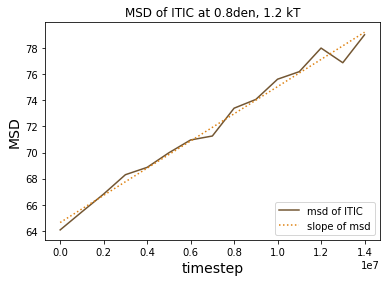

In [32]:
make_me_a_graph(state_dict = {"size": "small",
                              "density": 0.8,
                              "process": "quench",
                              "molecule": "ITIC",
                              "kT_reduced": 1.2})

slope is:
1.01730e-07


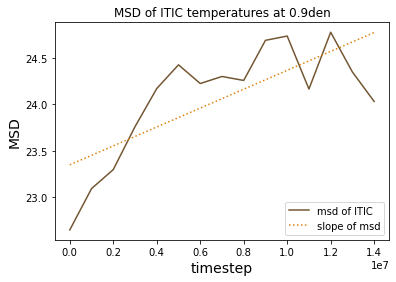

In [28]:
job_list = project.find_jobs(state_dict)

fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    tspf = job.sp['n_steps'] / 100
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
    y = msd[-15:]
    x = np.arange(0, len(y), 1) * tspf
    plt.plot(x, y, label=job.sp['kT_reduced'], color='#735632')
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, x*slope + intercept, linestyle = 'dotted', color = '#de8110')
    #plt.xlim(0, 6000)
    
plt.title("MSD of ITIC temperatures at %sden" % (job.sp['density']))
plt.xlabel("timestep", fontsize=14)
plt.ylabel("MSD", fontsize=14)

sline = mlines.Line2D([], [], color='#de8110', linestyle='dotted',
                       label='slope of msd' )
msdline = mlines.Line2D([], [], color='#735632', linestyle='solid',
                       label='msd of ITIC' )
ax.legend(loc='lower right', ncol=1, handles=[msdline, sline])
#plt.legend(handles=[sline])


print("slope is:")
print("%10.5e"% slope)

plt.show()